# NEURAL NETWORK- CAT & DOG CLASSIFICATION

Use Tensorflow 2 to train a neural network for the binary classification of cats and dogs based on images from this dataset. Images must be transformed from JPG to RGB (or grayscale) pixel values and scaled down. Experiment with different network architectures and training parameters documenting their influence of the final predictive performance. Use 5-fold cross validation to compute your risk estimates. While the training loss can be chosen freely, the reported cross-validated estimates must be computed according to the zero-one loss.


Tasks for the Project:

_Download and preprocess the dataset of cat and dog images

_Transform the images from JPG to RGB (or grayscale) pixel values and scale them down

_Split the dataset into training and testing sets

_Implement different neural network architectures and training parameters

_Train the neural network models using the training dataset

_Evaluate the predictive performance of each model on the testing dataset

_Document the influence of different network architectures and training parameters on the predictive performance

_Implement 5-fold cross-validation to compute risk estimates

_Compute the reported cross-validated estimates according to the zero-one loss

_Report the final predictive performance of the best performing neural network model.

Dense: fully connected layer
bath normalization need to addon each layer
shuffle=True
can add image augmentation

the smaller the learning rate the slower it is to reach minimum loss, big learning rate then it can shoot past the minimum 
can set lr in optimizer e.g Adam(lr=0.001)
padding = same 
type of pooling = max (maybe)

basic model: adam o.oo1 learning rate, one layer
start to increase layer and put in max pooling. put in decay learning rate

# Import packages 

In [68]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import zipfile
import pandas as pd
import glob

from google.colab import files

from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense,BatchNormalization
from tensorflow import keras
from keras.models import Sequential
from keras import callbacks
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import KFold

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.metrics import accuracy_score, zero_one_loss
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


# Loading data


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
zip = zipfile.ZipFile('/content/gdrive/MyDrive/CatsDogs.zip', 'r') 

zip.extractall()
zip.close()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#remove error picture
os.remove('./CatsDogs/Cats/666.jpg')
os.remove('./CatsDogs/Dogs/11702.jpg')

In [ ]:
#Convert
for folder_name in ("Cats", "Dogs"):
    folder_path = os.path.join("./CatsDogs", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        if fpath.endswith('.jpg'):
            image = Image.open(fpath)
            image = image.convert('RGB')
            image.save(fpath)


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [ ]:
def resize_images(folder_path, output_folder, new_size):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate over the files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            # Open the image
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)

            # Resize the image
            resized_image = image.resize(new_size)

            # Save the resized image to the output folder
            output_path = os.path.join(output_folder, filename)
            resized_image.save(output_path)

            # Close the image
            image.close()


In [ ]:
def create_zip_folder(folder_path, zip_path):
    # Create a zip file
    with zipfile.ZipFile(zip_path, 'w') as zipf:
        # Iterate over the files in the folder
        for root, _, files in os.walk(folder_path):
            for file in files:
                # Add each file to the zip file
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, folder_path))


In [ ]:
# Set the paths and parameters
cats_folder = "/content/CatsDogs/Cats"
dogs_folder = "/content/CatsDogs/Dogs"
resized_cats_folder = "resized_cats_60_30"
resized_dogs_folder = "resized_dogs_60_30"
new_size = (60,30)
zip_file_cats = "resized_cats_60_30.zip"
zip_file_dogs = "resized_dogs_60_30.zip"
# Resize the images in the Cats folder
resize_images(cats_folder, resized_cats_folder, new_size)

# Resize the images in the Dogs folder
resize_images(dogs_folder, resized_dogs_folder, new_size)

# Create a zip file containing the resized images
create_zip_folder(resized_cats_folder, zip_file_cats)
create_zip_folder(resized_dogs_folder, zip_file_dogs)


In [ ]:
files.download('resized_cats_60_30.zip')
files.download('resized_dogs_60_30.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Unzip resized data

In [2]:
zip_path = '/content/resized_cats_60_30.zip'
extract_path = '/content/Cats'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


zip_path = '/content/resized_dogs_60_30.zip'
extract_path = '/content/Dogs'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Train and test split


In [3]:
Dogs = glob.glob('/content/Dogs/*.jpg')
Cats = glob.glob('/content/Cats/*.jpg')


df_dogs = pd.DataFrame(Dogs, columns=["image"])
df_dogs["label"] = "dog"
df_cats = pd.DataFrame(Cats, columns=["image"])
df_cats["label"] = "cat"
total = pd.concat([df_dogs, df_cats],  ignore_index=True)
total

,image,label
0,/content/Dogs/1298.jpg,dog
1,/content/Dogs/10412.jpg,dog
2,/content/Dogs/33.jpg,dog
3,/content/Dogs/9619.jpg,dog
4,/content/Dogs/9092.jpg,dog
...,...,...
24993,/content/Cats/9901.jpg,cat
24994,/content/Cats/9182.jpg,cat
24995,/content/Cats/7457.jpg,cat
24996,/content/Cats/486.jpg,cat


In [4]:
#Split to train , validation and test set 
train_val, test = train_test_split(total, test_size=0.2, random_state=17)
train, val = train_test_split(train_val, test_size=0.2, random_state = 23)


In [5]:
#Image augmentation
def image_augmentation(target_size,shift_range):
  train_generator = ImageDataGenerator(rescale=1/255.,
  width_shift_range=shift_range, height_shift_range=shift_range, horizontal_flip=True) #normalized the pixel
  test_generator = ImageDataGenerator(rescale=1/255.)
  global train_set,test_set,val_set
  train_set = train_generator.flow_from_dataframe(dataframe = train,
                                               directory = None,
                                               x_col = 'image',
                                               y_col ='label',
                                               target_size=(target_size),
                                               batch_size=64,
                                               class_mode='binary',
                                               shuffle=True) 

  val_set = train_generator.flow_from_dataframe(dataframe = val,
                                               directory = None,
                                               x_col = 'image',
                                               y_col ='label',
                                               target_size=target_size,
                                               batch_size=64,
                                               class_mode='binary',
                                               shuffle=True) 



  test_set = test_generator.flow_from_dataframe(dataframe = test,
                                              directory = None,
                                               x_col = 'image',
                                               y_col ='label',
                                               target_size=target_size,
                                               batch_size=64,
                                               class_mode='binary',
                                               shuffle=True) 
  

In [73]:
target_size = (100,50)
shift_range = 0
image_augmentation(target_size,shift_range)

Found 15998 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [ ]:
len(total)

24998

# Neural Network implementation

In [49]:
def plot_accuracy(fitted_model):
  plt.plot(fitted_model.history["accuracy"],label = "Train", color = "blue")
  plt.plot(fitted_model.history["val_accuracy"],label = "Validation", color = "red", linestyle="dashed",markeredgecolor = "purple", markeredgewidth = 2)
  plt.title("Model 1: Training vs Test Accuracy", color = "darkred", size = 13)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.5, 1])
  plt.legend()  
  
def plot_structure(model):
  structure = tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96
  )
  return structure

# Baseline model

In [93]:
#baseline vgg model with 3 blocks of vgg
model = tf.keras.models.Sequential()


#input layer
model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(100, 50,3)))
model.add(MaxPooling2D(pool_size = (2,2))) 
model.add(Conv2D(64,(3, 3), padding ='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(128,(3, 3), padding ='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


#Compile
opt = SGD(lr=0.001, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_80 (Conv2D)          (None, 100, 50, 32)       896       
                                                                 
 max_pooling2d_76 (MaxPoolin  (None, 50, 25, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_81 (Conv2D)          (None, 50, 25, 64)        18496     
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 25, 12, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_82 (Conv2D)          (None, 25, 12, 128)       73856     
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 12, 6, 128)     

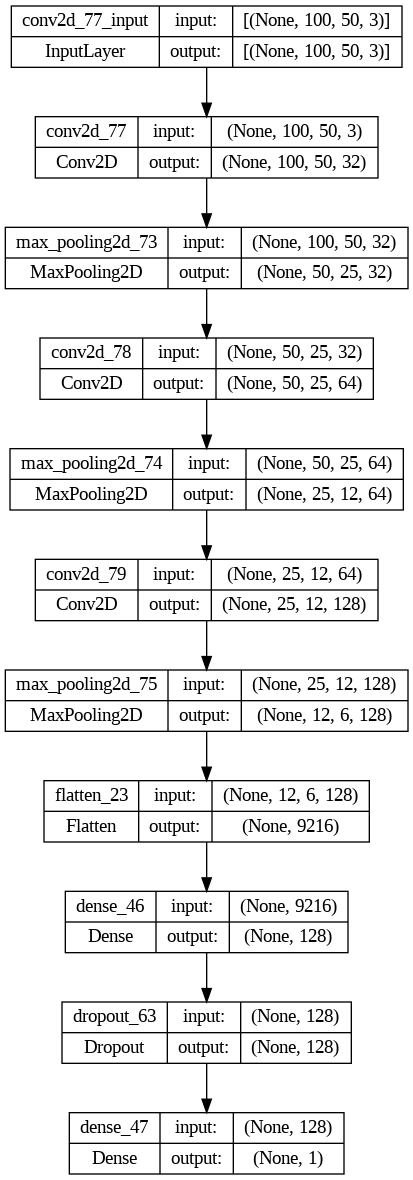

In [92]:
plot_structure(model)

In [94]:
fitted_model = model.fit(train_set, epochs=30, validation_data=val_set)


Epoch 1/30
250/250 [==============================] - 15s 56ms/step - loss: 0.6871 - accuracy: 0.5450 - val_loss: 0.6841 - val_accuracy: 0.5460
Epoch 2/30
250/250 [==============================] - 14s 55ms/step - loss: 0.6582 - accuracy: 0.6111 - val_loss: 0.6385 - val_accuracy: 0.6277
Epoch 3/30
250/250 [==============================] - 14s 56ms/step - loss: 0.6135 - accuracy: 0.6687 - val_loss: 0.5799 - val_accuracy: 0.6998
Epoch 4/30
250/250 [==============================] - 14s 55ms/step - loss: 0.5820 - accuracy: 0.6939 - val_loss: 0.5640 - val_accuracy: 0.7097
Epoch 5/30
250/250 [==============================] - 14s 55ms/step - loss: 0.5529 - accuracy: 0.7204 - val_loss: 0.5652 - val_accuracy: 0.6992
Epoch 6/30
250/250 [==============================] - 14s 57ms/step - loss: 0.5290 - accuracy: 0.7352 - val_loss: 0.5099 - val_accuracy: 0.7548
Epoch 7/30
250/250 [==============================] - 15s 59ms/step - loss: 0.5049 - accuracy: 0.7547 - val_loss: 0.4977 - val_accuracy:

In [95]:
result = model.evaluate(test_set)

79/79 [==============================] - 3s 38ms/step - loss: 0.5206 - accuracy: 0.8214


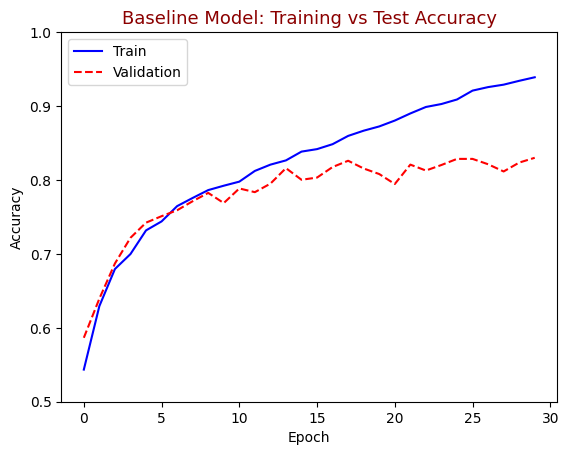

In [22]:
plt.plot(fitted_model.history["accuracy"],label = "Train", color = "blue")
plt.plot(fitted_model.history["val_accuracy"],label = "Validation", color = "red", linestyle="dashed",markeredgecolor = "purple", markeredgewidth = 2)
plt.title("Baseline Model: Training vs Test Accuracy", color = "darkred", size = 13)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend()

# Improve model

In [56]:
def custom_zero_one_loss(y_true, y_pred):
    y_pred_rounded = tf.round(y_pred)
    return tf.reduce_mean(tf.cast(tf.not_equal(y_true, y_pred_rounded), tf.float32))

In [89]:
#improved model
model = tf.keras.models.Sequential()


#input layer
model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(100,50,3)))
model.add(MaxPooling2D(pool_size = (2,2))) 
model.add(Dropout(0.2))

model.add(Conv2D(64,(3, 3), padding ='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3, 3), padding ='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(256,(3, 3), padding ='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))




decayed_lr = tf.compat.v1.train.exponential_decay(0.001,
                                        9000, 10000,
                                        0.95, staircase=True)
opt = tf.compat.v1.train.AdamOptimizer(decayed_lr)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_73 (Conv2D)          (None, 100, 50, 32)       896       
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 50, 25, 32)       0         
 g2D)                                                            
                                                                 
 dropout_59 (Dropout)        (None, 50, 25, 32)        0         
                                                                 
 conv2d_74 (Conv2D)          (None, 50, 25, 64)        18496     
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 25, 12, 64)       0         
 g2D)                                                            
                                                                 
 dropout_60 (Dropout)        (None, 25, 12, 64)      

In [41]:
fitted_model = model.fit(train_set, epochs=30, validation_data=val_set)


Epoch 1/30
250/250 [==============================] - 46s 168ms/step - loss: 0.6917 - accuracy: 0.5251 - val_loss: 0.6729 - val_accuracy: 0.5725
Epoch 2/30
250/250 [==============================] - 42s 170ms/step - loss: 0.6656 - accuracy: 0.6020 - val_loss: 0.6226 - val_accuracy: 0.6565
Epoch 3/30
250/250 [==============================] - 45s 182ms/step - loss: 0.6045 - accuracy: 0.6715 - val_loss: 0.5794 - val_accuracy: 0.6935
Epoch 4/30
250/250 [==============================] - 44s 176ms/step - loss: 0.5628 - accuracy: 0.7085 - val_loss: 0.5407 - val_accuracy: 0.7303
Epoch 5/30
250/250 [==============================] - 94s 378ms/step - loss: 0.5447 - accuracy: 0.7199 - val_loss: 0.5161 - val_accuracy: 0.7440
Epoch 6/30
250/250 [==============================] - 49s 197ms/step - loss: 0.5214 - accuracy: 0.7378 - val_loss: 0.5012 - val_accuracy: 0.7560
Epoch 7/30
250/250 [==============================] - 46s 183ms/step - loss: 0.5074 - accuracy: 0.7497 - val_loss: 0.4953 - val_ac

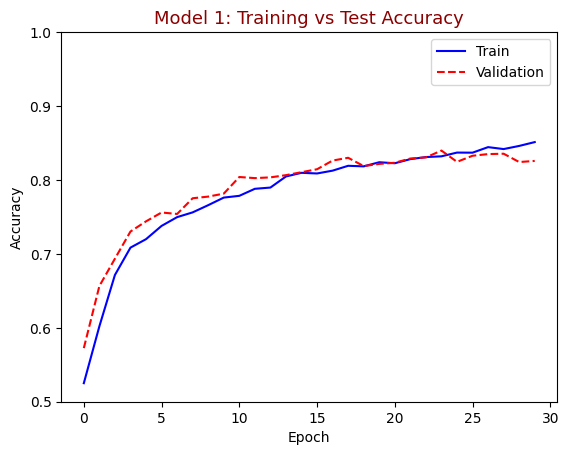

In [45]:
plot_accuracy(fitted_model)

In [54]:
result = model.evaluate(test_set)

79/79 [==============================] - 4s 48ms/step - loss: 0.3557 - accuracy: 0.8412


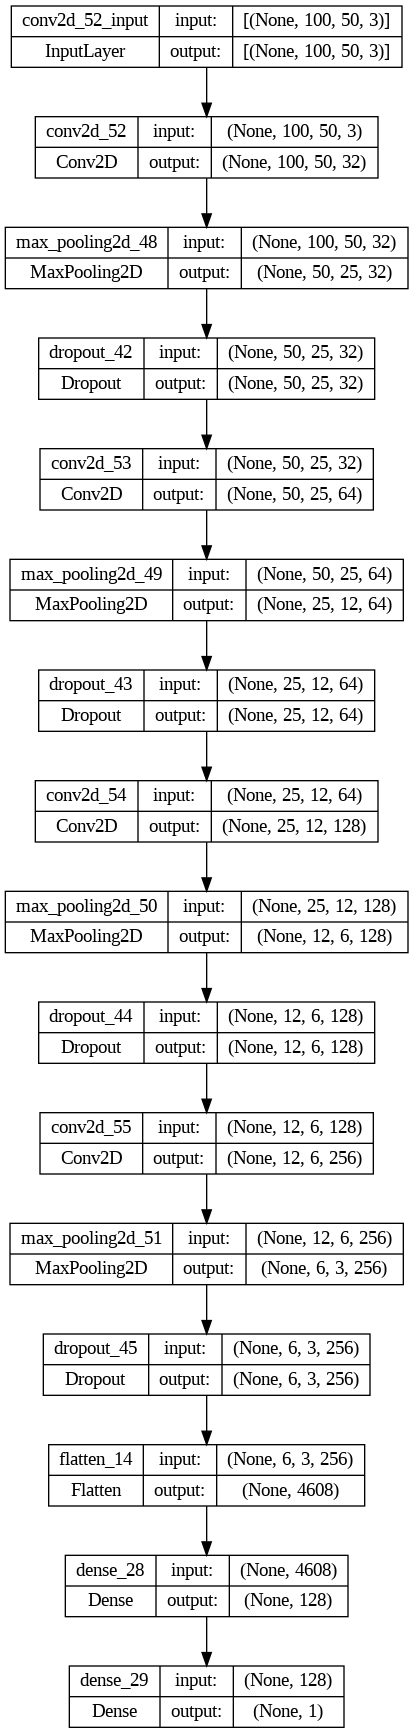

In [50]:
plot_structure(model)

In [75]:
#improved model
model = tf.keras.models.Sequential()


#input layer
model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(100,50,3)))
model.add(MaxPooling2D(pool_size = (2,2))) 
model.add(Dropout(0.2))



model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


#Compile
# global_step = tf.Variable(5000, trainable=False)
# decayed_lr = tf.compat.v1.train.exponential_decay(0.001,
#                                         9000, 10000,
#                                         0.95, staircase=True)
# opt = tf.compat.v1.train.AdamOptimizer(decayed_lr)

model.compile(loss=custom_zero_one_loss, metrics=['accuracy'])

model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 100, 50, 32)       896       
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 50, 25, 32)       0         
 g2D)                                                            
                                                                 
 dropout_48 (Dropout)        (None, 50, 25, 32)        0         
                                                                 
 flatten_17 (Flatten)        (None, 40000)             0         
                                                                 
 dense_34 (Dense)            (None, 128)               5120128   
                                                                 
 dense_35 (Dense)            (None, 1)                 129       
                                                     

In [61]:
fitted_model = model.fit(train_set, epochs=10, validation_data=val_set)


Epoch 1/10


ValueError: ignored

# Cross validation


In [71]:
#make image generators to use in k-fold

train_gen = ImageDataGenerator(rescale = 1.0/255.,
                                      zoom_range=0.2,
                                      rotation_range=0.2,
                                      shear_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest',
                                      width_shift_range=0.1, 
                                      height_shift_range=0.1,
                                      validation_split = 0.2)

validation_gen = ImageDataGenerator(rescale = 1.0/255.)

In [88]:
# cross entropy for baseline model
k = 5
kfold = KFold(n_splits=k, shuffle=True)


accuracies = np.zeros(k)
zeroonelosses = np.zeros(k)
val_loss = np.zeros(k)
val_acc = np.zeros(k)



for fold, (train_indices, val_indices) in enumerate(kfold.split(total)):

    train_data = total.iloc[train_indices]
    validation_data = total.iloc[val_indices]

    train_generator= train_gen.flow_from_dataframe(train_val,
                                                          directory = None,
                                                          x_col='image',
                                                          y_col='label',
                                                          target_size =(100,50),
                                                          class_mode='binary',
                                                          batch_size = 64)
    validation_generator = validation_gen.flow_from_dataframe(test,
                                                                    directory = None,
                                                                    x_col='image',
                                                                    y_col ='label',
                                                                    target_size = (100,50),
                                                                    class_mode = 'binary',
                                                                    batch_size=64)
    
    X_train, y_train = train_generator.next()
    history = model.fit(X_train,y_train,epochs=30)

    X_val , y_val = validation_generator.next()
    y_pred = model.predict(X_val)
    y_pred = np.round(y_pred).astype(int)

    accuracy = accuracy_score(y_val, y_pred)
    zerooneloss = zero_one_loss(y_val, y_pred)

    loss, acc = model.evaluate(X_val, y_val)

    # store results
    accuracies[fold] = accuracy
    zeroonelosses[fold] = zerooneloss
    val_loss[fold] = loss
    val_acc[fold] = acc

# average results across folds
avg_accuracy = np.mean(accuracies)
avg_zero_one_loss = np.mean(zeroonelosses)
avg_val_loss = np.mean(val_loss)
avg_val_acc = np.mean(val_acc)

print("Average accuracy (calculated manually): {:.3f}".format(avg_accuracy))
print("Average zero-one loss (calculated manually): {:.3f}".format(avg_zero_one_loss))
print("Average validation loss (calculated using model.evaluate): {:.3f}".format(avg_val_loss))
print("Average validation accuracy (calculated using model.evaluate): {:.3f}".format(avg_val_acc))

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Epoch 1/30
1/1 [==============================] - 1s 991ms/step - loss: 0.6914 - accuracy: 0.5625
Epoch 2/30
1/1 [==============================] - 0s 25ms/step - loss: 0.6883 - accuracy: 0.5938
Epoch 3/30
1/1 [==============================] - 0s 15ms/step - loss: 0.6814 - accuracy: 0.5938
Epoch 4/30
1/1 [==============================] - 0s 16ms/step - loss: 0.6836 - accuracy: 0.6562
Epoch 5/30
1/1 [==============================] - 0s 16ms/step - loss: 0.6871 - accuracy: 0.5938
Epoch 6/30
1/1 [==============================] - 0s 15ms/step - loss: 0.6687 - accuracy: 0.5938
Epoch 7/30
1/1 [==============================] - 0s 16ms/step - loss: 0.6793 - accuracy: 0.5938
Epoch 8/30
1/1 [==============================] - 0s 18ms/step - loss: 0.6543 - accuracy: 0.5938
Epoch 9/30
1/1 [==============================] - 0s 15ms/step - loss: 0.6776 - accuracy: 0.5938
Epo

In [90]:
# cross entropy for my model
k = 5
kfold = KFold(n_splits=k, shuffle=True)


accuracies = np.zeros(k)
zeroonelosses = np.zeros(k)
val_loss = np.zeros(k)
val_acc = np.zeros(k)



for fold, (train_indices, val_indices) in enumerate(kfold.split(total)):

    train_data = total.iloc[train_indices]
    validation_data = total.iloc[val_indices]

    train_generator= train_gen.flow_from_dataframe(train_val,
                                                          directory = None,
                                                          x_col='image',
                                                          y_col='label',
                                                          target_size =(100,50),
                                                          class_mode='binary',
                                                          batch_size = 64)
    validation_generator = validation_gen.flow_from_dataframe(test,
                                                                    directory = None,
                                                                    x_col='image',
                                                                    y_col ='label',
                                                                    target_size = (100,50),
                                                                    class_mode = 'binary',
                                                                    batch_size=64)
    
    X_train, y_train = train_generator.next()
    history = model.fit(X_train,y_train,epochs=30)

    X_val , y_val = validation_generator.next()
    y_pred = model.predict(X_val)
    y_pred = np.round(y_pred).astype(int)

    accuracy = accuracy_score(y_val, y_pred)
    zerooneloss = zero_one_loss(y_val, y_pred)

    loss, acc = model.evaluate(X_val, y_val)

    # store results
    accuracies[fold] = accuracy
    zeroonelosses[fold] = zerooneloss
    val_loss[fold] = loss
    val_acc[fold] = acc

# average results across folds
avg_accuracy = np.mean(accuracies)
avg_zero_one_loss = np.mean(zeroonelosses)
avg_val_loss = np.mean(val_loss)
avg_val_acc = np.mean(val_acc)

print("Average accuracy (calculated manually): {:.3f}".format(avg_accuracy))
print("Average zero-one loss (calculated manually): {:.3f}".format(avg_zero_one_loss))
print("Average validation loss (calculated using model.evaluate): {:.3f}".format(avg_val_loss))
print("Average validation accuracy (calculated using model.evaluate): {:.3f}".format(avg_val_acc))

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Epoch 1/30
1/1 [==============================] - 1s 718ms/step - loss: 0.7384 - accuracy: 0.4688
Epoch 2/30
1/1 [==============================] - 0s 16ms/step - loss: 0.9578 - accuracy: 0.5312
Epoch 3/30
1/1 [==============================] - 0s 17ms/step - loss: 0.6903 - accuracy: 0.5938
Epoch 4/30
1/1 [==============================] - 0s 14ms/step - loss: 0.7043 - accuracy: 0.4688
Epoch 5/30
1/1 [==============================] - 0s 14ms/step - loss: 0.7012 - accuracy: 0.4688
Epoch 6/30
1/1 [==============================] - 0s 14ms/step - loss: 0.6934 - accuracy: 0.5625
Epoch 7/30
1/1 [==============================] - 0s 16ms/step - loss: 0.6917 - accuracy: 0.5312
Epoch 8/30
1/1 [==============================] - 0s 14ms/step - loss: 0.6886 - accuracy: 0.5312
Epoch 9/30
1/1 [==============================] - 0s 15ms/step - loss: 0.6903 - accuracy: 0.5312
Epo